## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [1]:
# import libraries
import re
import requests as req
import numpy as np
import pandas as pd
import assets.script as sc
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
from calendar import Calendar
%matplotlib inline

In [2]:
# import sql library
from psycopg2 import sql
import psycopg2 as pg

# define paths
from pathlib import Path
data_path = Path('./data')

In [3]:
# display table names
display_tables = sc.sql_read_tables()
for tables in display_tables:
    print(tables)

flights
flights_test
fuel_comsumption
pass_sample
passengers
sample
temptable
test_table


In [4]:
# query for tables
limit = 100000
sample_size = '{}k'.format(int(limit/1000))


for tables in display_tables:
    query = sql.SQL(
        "SELECT * FROM {t} \
            LIMIT {l};").format(
            t = sql.Identifier(tables),
            l = sql.Literal(limit)
        )
        
    filename = '{}_{}_sample.csv'.format(tables, sample_size)
    overwrite = False
    
    # sql call
    df = sc.make_csv(query, filename, overwrite)

File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...


In [5]:
# transfer sample of tables to dataframes
df_flights = pd.read_csv(data_path / 'flights_{}_sample.csv'.format(sample_size))
df_flights_test = pd.read_csv(data_path / 'flights_test_{}_sample.csv'.format(sample_size))
df_fuel_comsumption = pd.read_csv(data_path / 'fuel_comsumption_{}_sample.csv'.format(sample_size))
df_pass_sample = pd.read_csv(data_path / 'pass_sample_{}_sample.csv'.format(sample_size))
df_passengers = pd.read_csv(data_path / 'passengers_{}_sample.csv'.format(sample_size))
df_sample = pd.read_csv(data_path / 'sample_{}_sample.csv'.format(sample_size))
df_test_table = pd.read_csv(data_path / 'test_table_{}_sample.csv'.format(sample_size))

df_table_names = [df_flights, df_flights_test, df_fuel_comsumption, df_pass_sample, df_passengers, df_sample, df_test_table]

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

##### Look for columns describing delay

In [6]:
# search for columns that describe delays
regex = r"(.*delay.*)"
indices, results = sc.search_data(df_flights, regex)
results

['dep_delay',
 'arr_delay',
 'carrier_delay',
 'weather_delay',
 'nas_delay',
 'security_delay',
 'late_aircraft_delay']

##### Preliminary EDA

In [7]:
print(df_flights[results].isnull().sum())
# most delays appear to have many missing values; will ignore them for now

dep_delay               3133
arr_delay               3723
carrier_delay          73689
weather_delay          73689
nas_delay              73689
security_delay         73689
late_aircraft_delay    73689
dtype: int64


In [8]:
# early arrivals|departures without null values
df_flights_delay = df_flights[['dep_delay', 'arr_delay']].dropna().reset_index(drop=True)
print(df_flights_delay.isnull().sum())
print(df_flights_delay.index)
df_flights_delay.describe()

dep_delay    0
arr_delay    0
dtype: int64
RangeIndex(start=0, stop=96277, step=1)


,dep_delay,arr_delay
count,96277.000000,96277.000000
mean,21.840512,17.573450
std,68.435427,70.287878
min,-32.000000,-88.000000
25%,-5.000000,-13.000000
50%,-1.000000,-3.000000
75%,17.000000,18.000000
max,1615.000000,1597.000000


These numbers are terrible.

##### Check for normal distributions

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.46445733308792114 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 16281.315486526786 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 6.635684409030094
kurtosis, tail spread (< 3 is best): 73.27290163045704


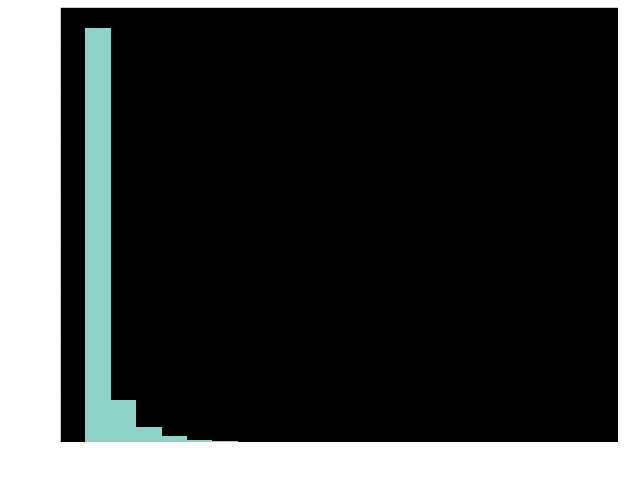

In [9]:
sc.check_normal_dist(df_flights_delay['dep_delay'])

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.5947854518890381 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 12638.842786035922 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 6.209374232134813
kurtosis, tail spread (< 3 is best): 66.36765450338011


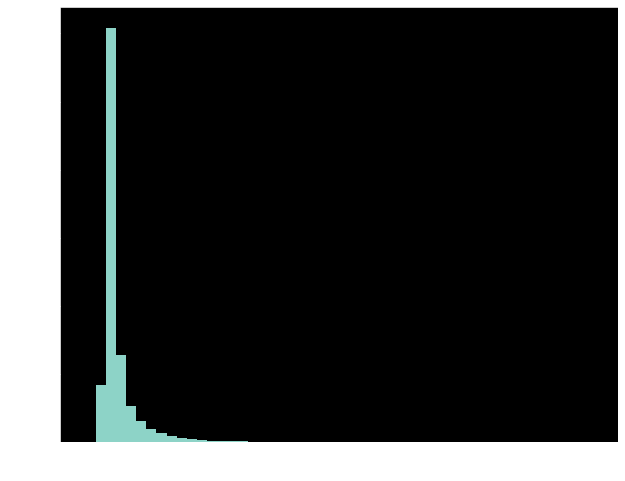

In [10]:
sc.check_normal_dist(df_flights_delay['arr_delay'], bins=50)

These are really not normal. Also, extremely skewed.

##### Filter outliers and redo the normal distribution checks

In [11]:
df = sc.filter_outliers(df_flights_delay, df_flights_delay['arr_delay'])
df.reset_index(inplace=True, drop=True)
df = sc.filter_outliers(df, df['dep_delay'])

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.8135808706283569 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 5865.607979487759 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 1.9776802142480534
kurtosis, tail spread (< 3 is best): 4.470678047775033


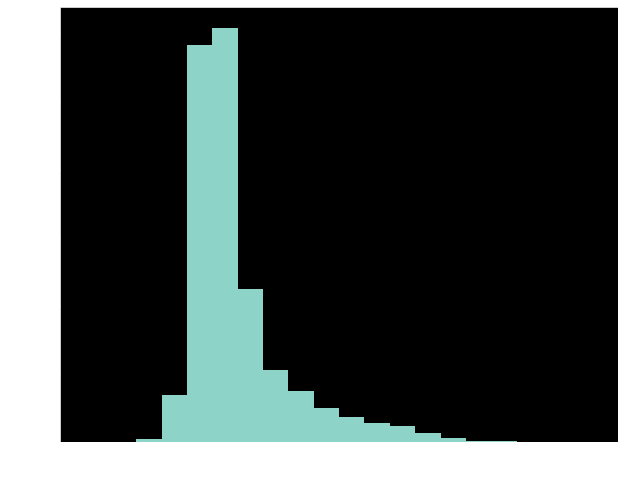

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.6654062867164612 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 10910.59739584144 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.32689942902098
kurtosis, tail spread (< 3 is best): 5.215487610741231


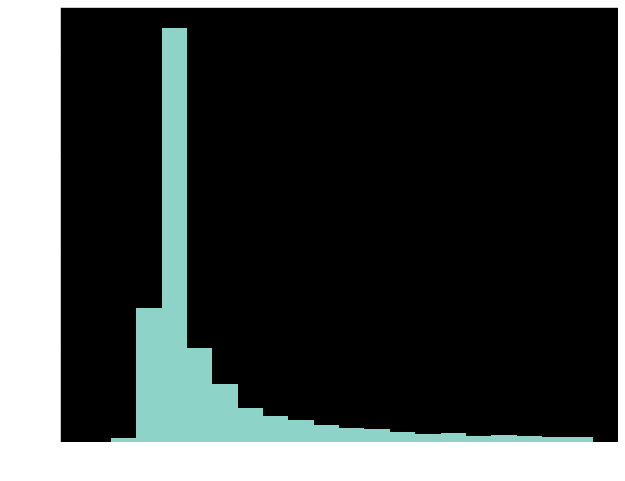

,dep_delay,arr_delay
count,91502.000000,91502.000000
mean,9.956176,5.643308
std,27.637826,31.450826
min,-32.000000,-88.000000
25%,-5.000000,-13.000000
50%,-1.000000,-4.000000
75%,12.000000,13.000000
max,135.000000,227.000000


In [12]:
sc.check_normal_dist(df['arr_delay'])
sc.check_normal_dist(df['dep_delay'])
df.describe()

These are much better. The mean trends closer to zeo, and the max values aren't nearly so bad. Though, it still skews positive, these numbers make more sense.

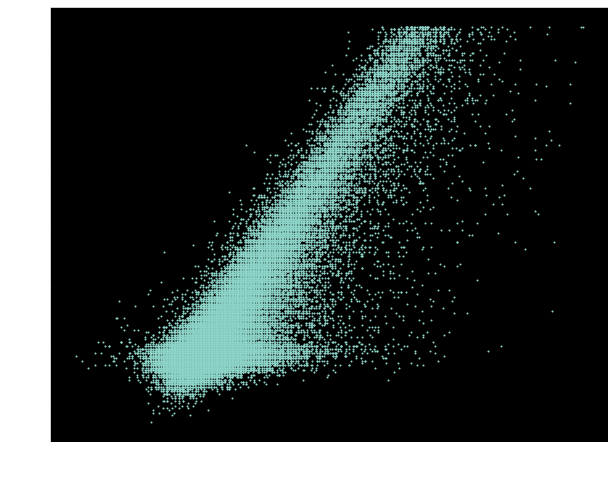

In [13]:
sc.graph_eda('scatter', df['arr_delay'], df['dep_delay'], marker_size=1)

There appears to be a correlation between the two, arr_delay and dep_delay. What's interesting is that the effect of departure delays on arrival delays appear to be wide one way. Arrival delay is less correlated to departure than the other way around.

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

##### Define a function that takes samples per time period

In [14]:
# search for columns that describe delays
regex = r"(.*date.*)"

for i, table in enumerate(df_table_names):
    indices, results = sc.search_data(table, regex)
    # print(i)
    # print(indices)
    print(results)

['fl_date']
['fl_date']
[]
[]
[]
['fl_date']
['fl_date']


Only one column with associated dates. Take 100k samples from each month.

In [15]:
df_flights_by_month = []

for i in range(0,12):
    df_flights_by_month.append(sc.sql_search_date(table='flights', y=2019, m=i+1).sort_values(by='fl_date'))

File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...


In [16]:
for flights in df_flights_by_month:
    print(flights)

        fl_date mkt_unique_carrier branded_code_share mkt_carrier  \
454  2019-01-01                 AA                 AA          AA   
34   2019-01-01                 DL       DL_CODESHARE          DL   
800  2019-01-01                 AA                 AA          AA   
474  2019-01-01                 AA       AA_CODESHARE          AA   
46   2019-01-01                 WN                 WN          WN   
..          ...                ...                ...         ...   
264  2019-01-31                 AA       AA_CODESHARE          AA   
244  2019-01-31                 UA       UA_CODESHARE          UA   
177  2019-01-31                 AA                 AA          AA   
635  2019-01-31                 UA       UA_CODESHARE          UA   
0    2019-01-31                 UA       UA_CODESHARE          UA   

     mkt_carrier_fl_num op_unique_carrier tail_num  op_carrier_fl_num  \
454                2522                AA   N836NN               2522   
34                 5229  

1
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 3.6708313305855467
kurtosis, tail spread (< 3 is best): 18.526514754869954


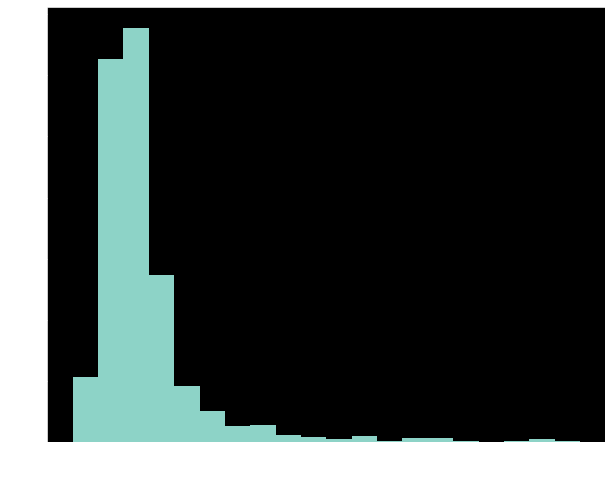

2
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 5.7403826402581695
kurtosis, tail spread (< 3 is best): 54.38779042803529


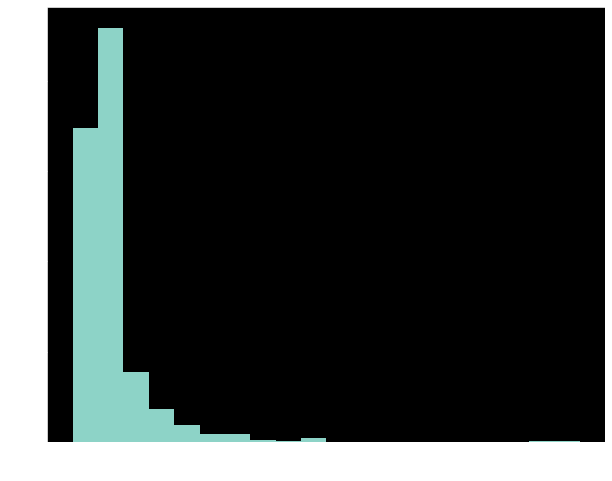

3
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 14.625042602862564
kurtosis, tail spread (< 3 is best): 321.24064938650554


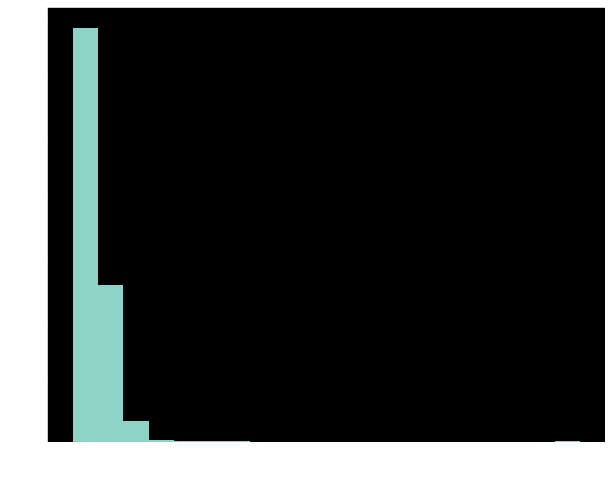

4
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 5.437145802273777
kurtosis, tail spread (< 3 is best): 45.609726323019416


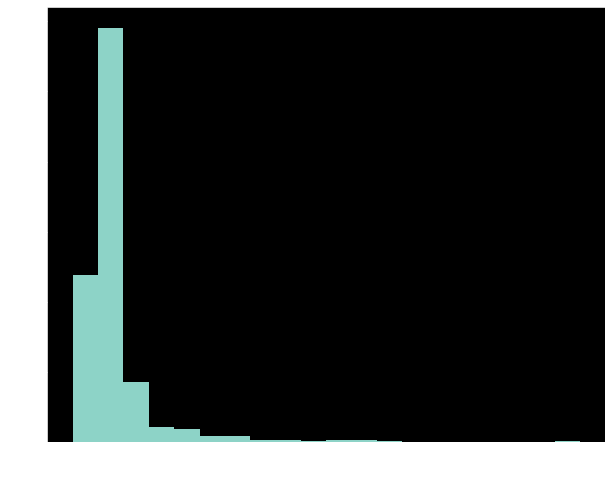

5
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 5.616541531008963
kurtosis, tail spread (< 3 is best): 48.82498613976634


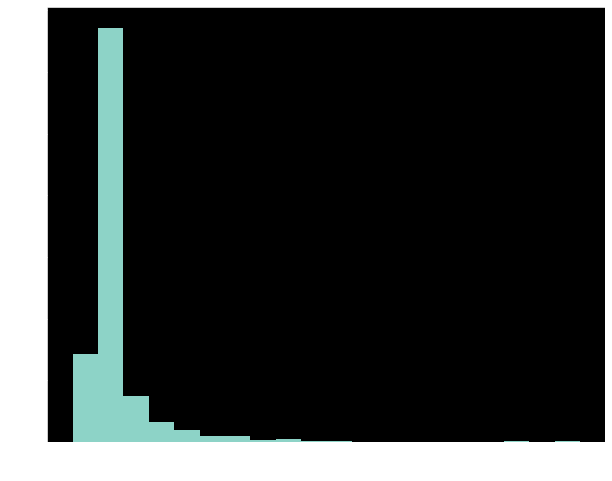

6
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 5.0262142973610855
kurtosis, tail spread (< 3 is best): 41.61176793196026


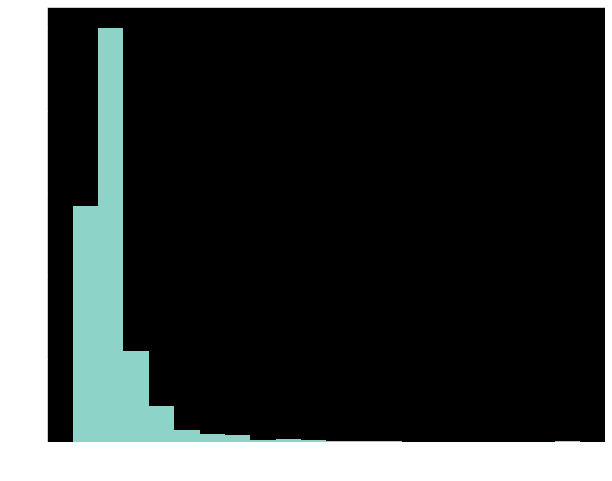

7
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 3.479306531787309
kurtosis, tail spread (< 3 is best): 15.402962919353778


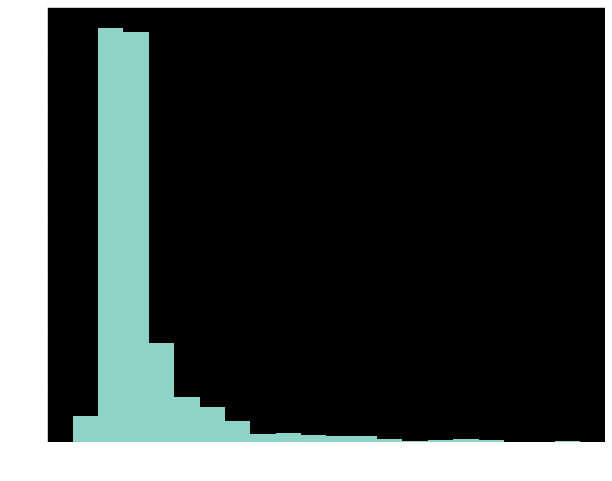

8
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 6.630722614026439
kurtosis, tail spread (< 3 is best): 60.9807660169791


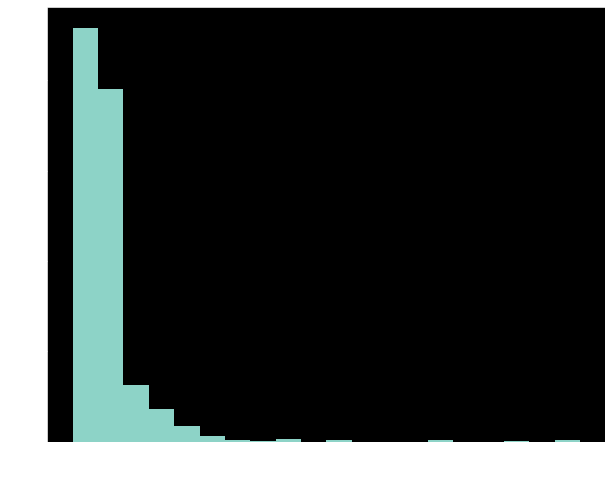

9
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 8.197746921125686
kurtosis, tail spread (< 3 is best): 97.57275132854491


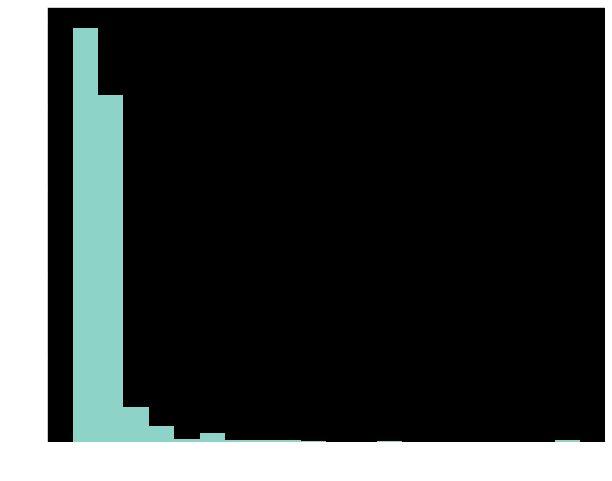

10
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 4.890464822414068
kurtosis, tail spread (< 3 is best): 35.56095801962872


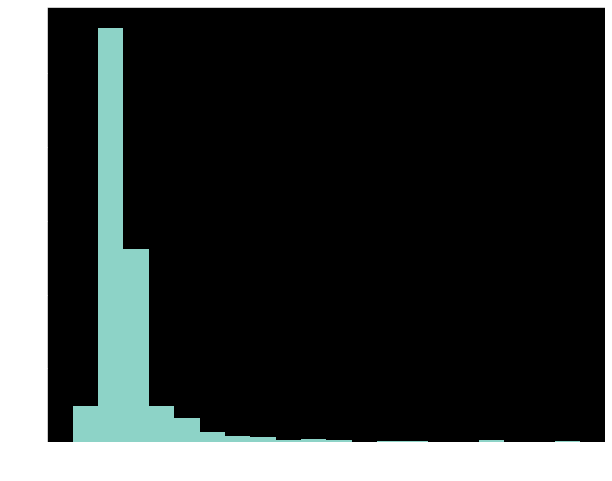

11
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 7.655442794976301
kurtosis, tail spread (< 3 is best): 91.03197294168739


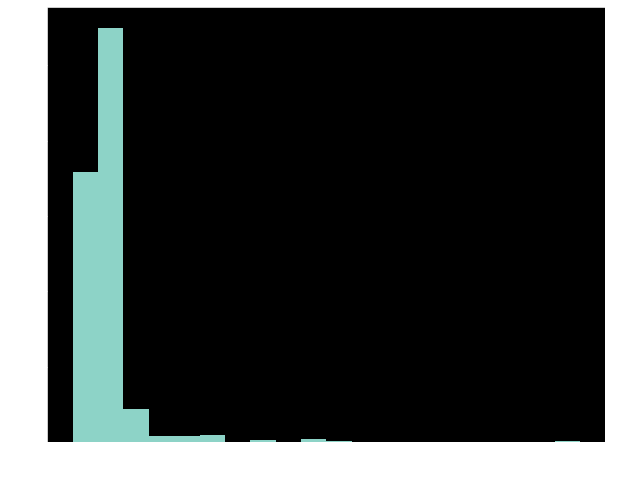

12
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: nan , p-value: 1.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: nan , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 5.206706947847035
kurtosis, tail spread (< 3 is best): 41.49688317828655


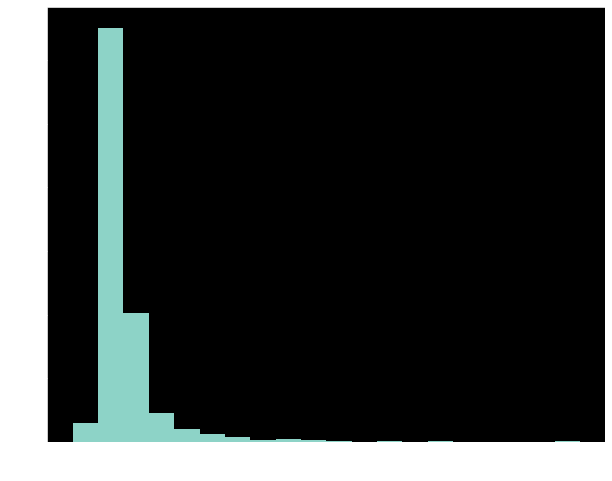

In [17]:
for i,month in enumerate(df_flights_by_month):
    print(i+1)
    sc.check_normal_dist(month['arr_delay'])

In [18]:
df_flights_by_month_noouts = []

for month in df_flights_by_month:
    df_flights_by_month_noouts.append(sc.filter_outliers(month.dropna(subset=['arr_delay']), month['arr_delay'].dropna()))

1
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.8579630255699158 , p-value: 2.268243047513922e-28

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 34.52230067704784 , critical values: [0.574 0.653 0.784 0.914 1.087] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 1.7721275528335798
kurtosis, tail spread (< 3 is best): 4.330177286283774


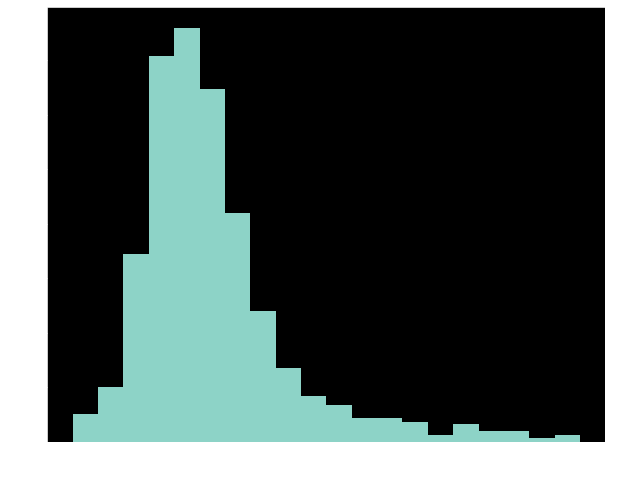

2
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7804376482963562 , p-value: 8.220261382659027e-34

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 62.2918235970767 , critical values: [0.574 0.653 0.784 0.914 1.087] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.201187105645989
kurtosis, tail spread (< 3 is best): 5.794192790021711


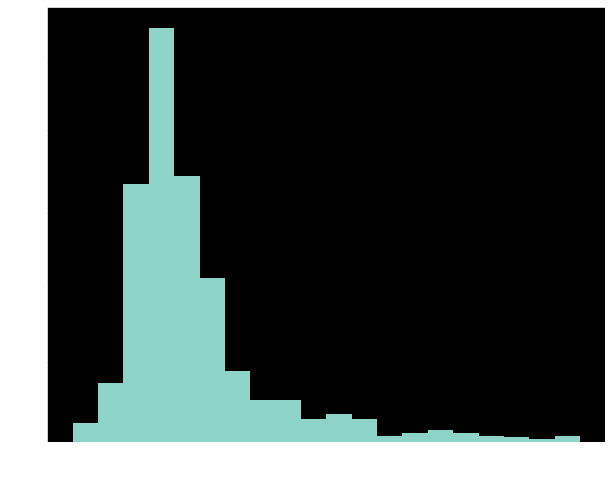

3
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.782945990562439 , p-value: 4.240314853973159e-34

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 60.3176756973312 , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.2374207560259363
kurtosis, tail spread (< 3 is best): 6.162881152585597


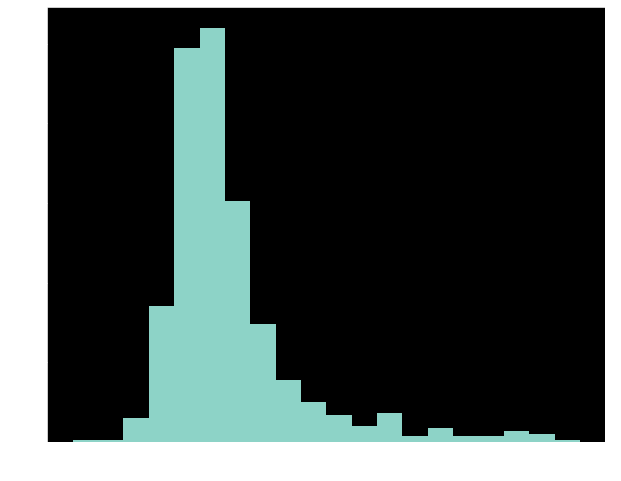

4
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7875063419342041 , p-value: 1.4925823907531649e-33

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 56.40182873826177 , critical values: [0.574 0.653 0.784 0.914 1.087] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.263516437485606
kurtosis, tail spread (< 3 is best): 6.541932376694476


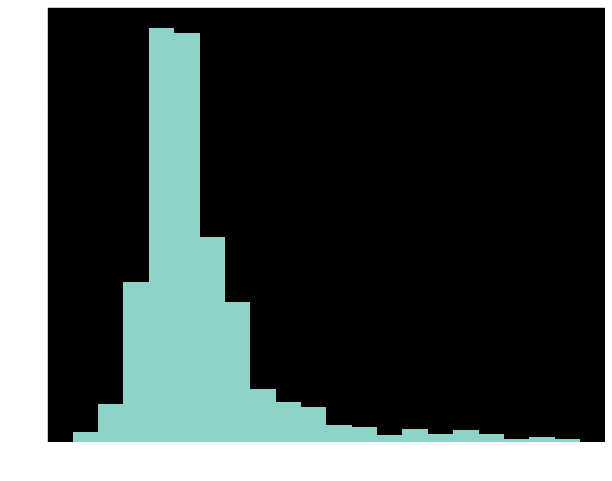

5
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7235678434371948 , p-value: 5.787204815402473e-37

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 79.55437767188187 , critical values: [0.574 0.653 0.784 0.914 1.087] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.58272794543387
kurtosis, tail spread (< 3 is best): 7.848612366490091


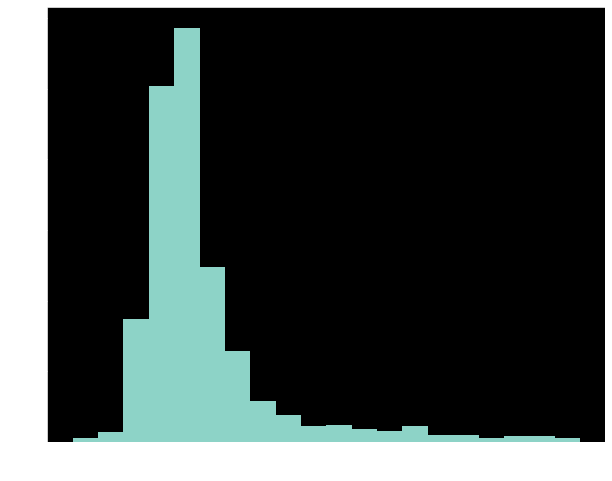

6
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.8144686818122864 , p-value: 7.635756220667451e-32

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 54.714780003440865 , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 1.946326156204461
kurtosis, tail spread (< 3 is best): 4.555654929210533


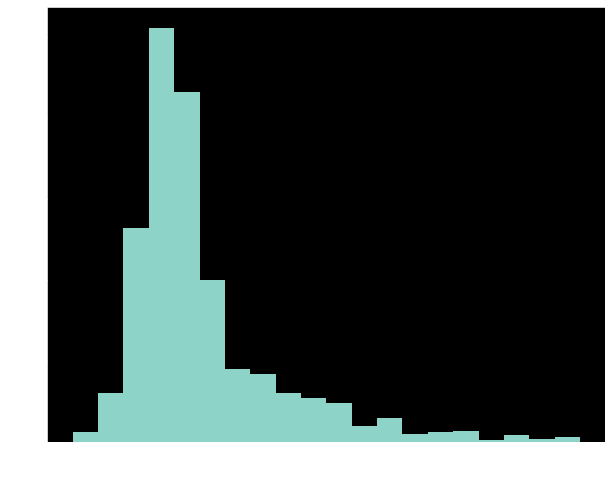

7
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7930933833122253 , p-value: 4.5075818617318374e-33

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 61.3112834774596 , critical values: [0.574 0.653 0.784 0.914 1.087] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.0719161051417507
kurtosis, tail spread (< 3 is best): 5.033644520083828


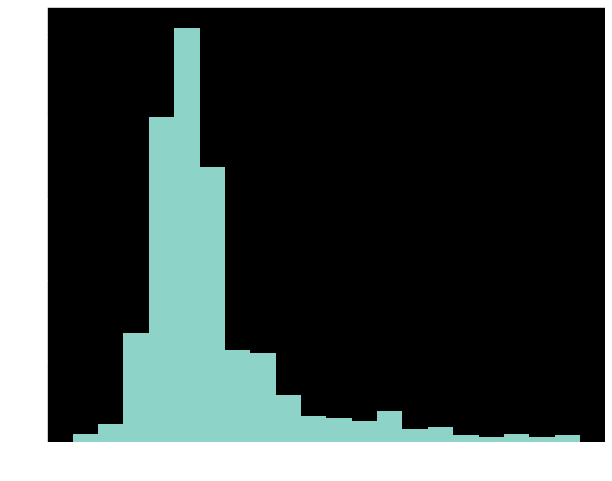

8
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7417473793029785 , p-value: 2.4391667415483522e-36

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 78.72646229836391 , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.343335613682923
kurtosis, tail spread (< 3 is best): 6.144055033853995


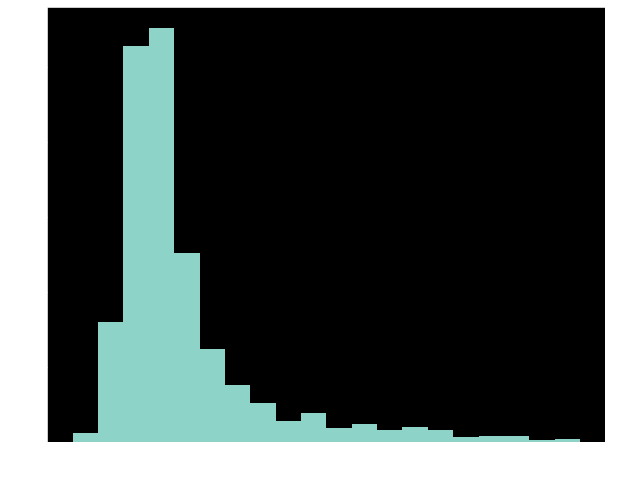

9
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.7935289144515991 , p-value: 2.4975660513653986e-33

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 52.55559802038056 , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.3030390621570493
kurtosis, tail spread (< 3 is best): 7.30090467309625


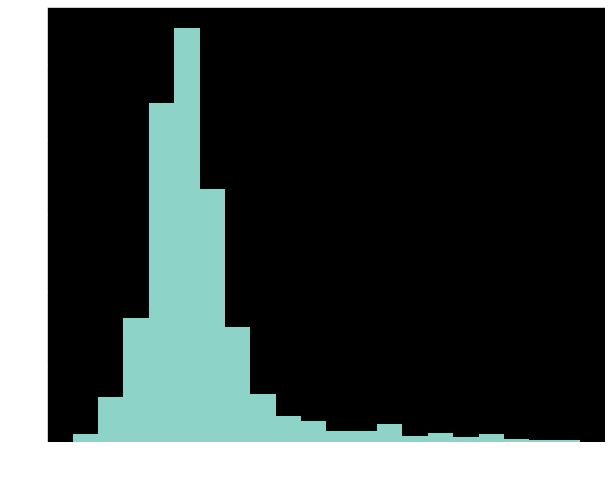

10
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.8187134861946106 , p-value: 9.722454413186423e-32

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 47.59431209825425 , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.0712843676032864
kurtosis, tail spread (< 3 is best): 5.790385353134323


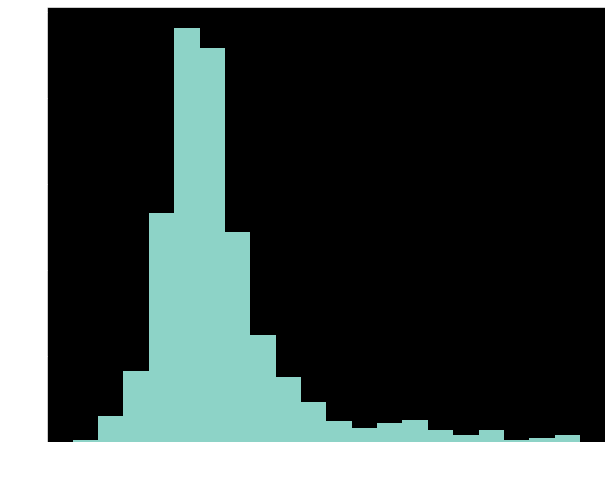

11
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.8097801804542542 , p-value: 3.014151186500661e-32

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 37.37715797702083 , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.4870221104369925
kurtosis, tail spread (< 3 is best): 10.409645289973758


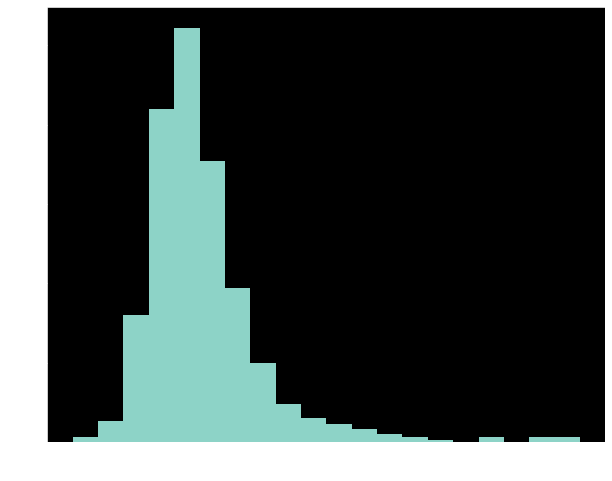

12
Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.8098911643028259 , p-value: 3.6262407928022205e-32

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 48.29229878451872 , critical values: [0.574 0.653 0.784 0.914 1.088] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.1391884876960594
kurtosis, tail spread (< 3 is best): 6.0821615617142015


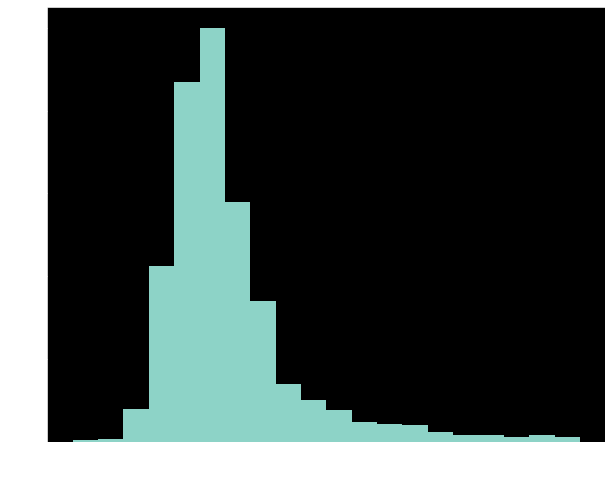

In [19]:
for i,month in enumerate(df_flights_by_month_noouts):
    print(i+1)
    sc.check_normal_dist(month['arr_delay'])

In [20]:
for i, month in enumerate(df_flights_by_month_noouts):
    print(i+1, month['arr_delay'].dropna().mean())
    print(i+1, month['arr_delay'].dropna().median())

1 -1.3262935586061246
1 -7.0
2 4.180379746835443
2 -5.0
3 0.5127942681678608
3 -7.0
4 -0.49635036496350365
4 -7.0
5 1.0094438614900314
5 -7.0
6 5.452653485952133
6 -3.0
7 1.0526315789473684
7 -7.0
8 4.9866255144032925
8 -6.0
9 -5.1671826625387
9 -10.0
10 -2.871663244353183
10 -8.0
11 -4.034126163391933
11 -8.0
12 0.7463617463617463
12 -6.0


February, June, and August seem to have the most delays. February and June might coincide with New years, and summer vacations. August is return to school? Not certain.

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [21]:
origin_locations = flights['origin_city_name'].unique()

In [22]:
base_url = 'https://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=5964df60e1c04a11883230245221204&q&format=json'

# locations
locations = origin_locations

# params
dates = [
    '2019-01-01',
    '2019-02-01',
    '2019-03-01',
    '2019-04-01',
    '2019-05-01',
    '2019-06-01',
    '2019-07-01',
    '2019-08-01',
    '2019-09-01',
    '2019-10-01',
    '2019-11-01',
    '2019-12-01']
enddates = [
    '2019-01-31',
    '2019-02-28',
    '2019-03-31',
    '2019-04-30',
    '2019-05-31',
    '2019-06-30',
    '2019-07-31',
    '2019-08-31',
    '2019-09-30',
    '2019-10-31',
    '2019-11-30',
    '2019-12-31']

In [23]:
len(locations)

167

In [24]:
weather_conditions = pd.read_csv(data_path / 'weather_conditions.csv', usecols=[0,1,2], sep=',')

In [25]:
weather_conditions.drop_duplicates(inplace=True)
weather_conditions.sort_values(by='overhead_code', inplace=True)

In [26]:
weather_conditions

# rain or like weather = > 263
# sunny = 113
# cloudy = 116, 119, 122
# snow = 227, 230

,overhead_code,daycondition,NightCondition
0,113,Sunny,Clear
40,116,Partly cloudy,Partly cloudy
80,119,Cloudy,Cloudy
120,122,Overcast,Overcast
160,143,Mist,Mist
200,176,Patchy rain possible,Patchy rain possible
240,179,Patchy snow possible,Patchy snow possible
280,182,Patchy sleet possible,Patchy sleet possible
320,185,Patchy freezing drizzle possible,Patchy freezing drizzle possible
360,200,Thundery outbreaks possible,Thundery outbreaks possible


In [27]:
weather_loc = {}

# for each location, save monthly weather
for location in locations:
    
    weather_req = []
    
    for i in range(0,12):
        
        # payload using params
        payload = dict(
            date=dates[i],
            enddate=enddates[i],
            q=location)
        
        weather_req.append(req.get(url=base_url, params=payload).json())
    
    weather_loc[location] = weather_req

In [121]:
cal = Calendar()
df_weather = pd.DataFrame(columns=['location', 'date', 'time', 'tempC', 'condition'])
df_placeholder = pd.DataFrame(columns=['location', 'date', 'time', 'tempC', 'condition'])
df_dict = {}

for location in locations:
    
    for m in range(0,12):
        for i,d in enumerate([x for x in cal.itermonthdates(2019, m+1) if x.month == m+1]):
            
            for j in range(len(weather_loc[location][m]['data']['weather'][i]['hourly'])):
                df_placeholder.loc[j+1, 'location'] = location
                df_placeholder.loc[j+1, 'date'] = d
                df_placeholder.loc[j+1, 'time'] = weather_loc[location][m]['data']['weather'][i]['hourly'][j]['time']
                df_placeholder.loc[j+1, 'tempC'] = int(weather_loc[location][m]['data']['weather'][i]['hourly'][j]['tempC'])
                df_placeholder.loc[j+1, 'condition'] = int(weather_loc[location][m]['data']['weather'][i]['hourly'][j]['weatherCode'])
            
            df_weather = pd.concat([df_weather, df_placeholder], ignore_index=True, axis=0)
        

In [146]:
df_weather_copy = df_weather.copy()

In [147]:
# add 6 hours to make it easier to separate into night/day
df_weather_copy['time'] = [time+600 for time in df_weather['time'].astype(int)]
df_weather_copy['tempC'] = [temp for temp in df_weather['tempC'].astype(int)]
df_weather_copy['condition'] = [con for con in df_weather['condition'].astype(int)]

In [148]:
daytime = []

for i,time in df_weather_copy['time'].iteritems():
    
    # code the time to 24 hours
    if time >= 2400:
        df_weather_copy.loc[i, 'time'] = time - 2400
    
    # convert 
    if df_weather_copy.loc[i, 'time'] >= 1200:
        daytime.append(0) # day
    else:
        daytime.append(1) # night

df_weather_copy = df_weather_copy.join(pd.Series(daytime, name='day/night'))

In [149]:
# rain or like weather = > 263
# sunny = 113
# cloudy = 116, 119, 122
# snow = 227, 230

df_weather_copy = df_weather_copy.drop(['time'], axis=1).groupby(['location', 'date', 'day/night'])['condition'].aggregate('median')

In [150]:
df_weather_copy = df_weather_copy.reset_index()

In [151]:
conditions = []

for condition in df_weather_copy['condition']:
    if condition > 250:
        conditions.append('rain')
    elif condition > 200 and condition <= 250:
        conditions.append('snow')
    elif condition < 115:
        conditions.append('sunny')
    else:
        conditions.append('cloudy')


In [152]:
df_weather_copy = df_weather_copy.join(pd.Series(conditions, name='cond_desc'))

In [154]:
df_weather_copy

,location,date,day/night,condition,cond_desc
0,"Abilene, TX",2019-01-01,0,117.5,cloudy
1,"Abilene, TX",2019-01-01,1,116.0,cloudy
2,"Abilene, TX",2019-01-02,0,192.5,cloudy
3,"Abilene, TX",2019-01-02,1,191.0,cloudy
4,"Abilene, TX",2019-01-03,0,266.0,rain
...,...,...,...,...,...
121905,"Wichita, KS",2019-12-29,1,120.5,cloudy
121906,"Wichita, KS",2019-12-30,0,113.0,sunny
121907,"Wichita, KS",2019-12-30,1,206.0,snow
121908,"Wichita, KS",2019-12-31,0,120.5,cloudy


#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [ ]:
df_flights

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

#### **Task 6**: How many states cover 50% of US air traffic? 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?